<a href="https://colab.research.google.com/github/fire-classifying/fireclass/blob/master/Proyecto_Incendios_v_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Proyecto: Predicción tipo de Incendios

Dividimos el análisis en los siguientes apartados:


<b>1. Introducción. Comprender el problema</b>

<b>2. Analítica exploratoria y preparación de datos</b>

<b>3. Estudio de variables:</b>

  * Estudio univariable
  * Estudio multivariable
 
<b>4. Tratamiento de los datos</b>

<b>5. Selección del modelo Machine Learning<b/> 
    
<b>6. Medición de Rendimiento de Modelos</b>



In [1]:
# Ejecuta esta celda para activar tu cuenta de Google Drive.
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


## 1. Introducción

En este proyecto se tratará de predecir el tipo de incendio que se va a generar (conato, incendio o gran incendio) a partir de distintos factores físicos, como el (clima, relieve, tipo de vegetación, humedad de la vegetación,etc), con el fin de que los equipos de extinción puedan priorizar sus recursos en función del tipo de incendio que se pueden encuentrar. De hecho, la franja horaria para atajar un incendio son las primeras horas, con lo que si se conoce el tipo de peligro de incendio que se puede generar, con una buena actuación a primera hora, ese incendio se puede atajar, y así evitar males mayores... Ya que tenemos que elaborar la base de datos extrayendo métricas de imágenes de satélite (Landsat y Modis).

Definición de qué es conato, incendio o gran incendio:

https://civio.es/espana-en-llamas/incendios-y-hectareas-quemadas/

El término <b>incendio</b> se usa de forma indiscriminada para referirse a cualquier siniestro provocado por el fuego. La Estadística General de Incendios Forestales (EGIF) del Ministerio distingue los siguientes tipos según la extensión de suelo afectada:

* <b>Conato:</b> siniestros que afectan a una superficie inferior a una hectárea.
* <b>Incendio:</b> todo fuego igual o superior a una hectárea.
* <b>Gran Incendio Forestal (GIF):</b> subtipo de incendio. Reciben esta denominación cuando el área quemada es igual o superior a 500 hectáreas.

Las hectáreas quemadas las tenemos, pero creemos que es mucho más difícil predecir las hectáreas que el tipo de categoría que tendrá el incendio...


### Variables del dataset:
    
* <b>ID</b>: Identificador del incendio
* <b>Año</b>: 
* <b>Fecha</b>:
* <b>Superficie quemada</b>: Siempre será mayor de 10 hectáreas
* <b>Superficie arbolada</b>: hectáreas de la superficie de árbol
* <b>Superficie pastizal</b>: Hectáreas de superficie pasto
* <b>Superficie Matorral</b>: Hectáreas de superficie matorral
* <b>W_arb</b>: peso arbolado quemado en tanto por uno
* <b>W_pasto</b>: Peso pasto quemado en tanto por uno
* <b>W_matorr</b>: Peso matorral quemado en tanto por
* <b>rk_Cuenca</b>:
* <b>rk_Hist_Cu</b>: Riesgo históricos en la cuenca
* <b>rk_Histo_us</b>: Riesgo histórico suceso****
* <b>rk_orograf</b>: en función de la pendiente
* <b>rk_peligro</b>: Zona peligro incendios
* <b>rk_pte</b>: Riesgo pendientes
* <b>Vuln_equip</b>: Vulnerabilidad por equipamientos de uso público
* <b>Vuln_forveg</b>: Vulnerabilidad de formación vegetal
* <b>Vinfraes</b>: Vulnerabilidad de infraestructuras lineales
* <b>Vpathis</b>: Vulnerabilidad de elementos de patrimonio históricos
* <b>Vurbano</b>: Vulnerabilidad de zonas urbanas
* <b>LST</b>: Temperaturas Modis
* <b>rk_combUSIF</b>: Riesgo por tipo de combustible arbóreo
* <b>rk_combCuencExtr</b>: Riesgo de combustible en esa cuenca por lluvia media
* <b>rk_combCuencSup</b>: Riesgo de combustible por superficie de la cuenca

## 2. Realizar un análisis descriptivo del dataset (EDA)


In [2]:
!pip install fastai==0.7.0

     |████████████████████████████████| 122kB 6.5MB/s 
     |████████████████████████████████| 1.5MB 42.9MB/s 
     |████████████████████████████████| 496.4MB 34kB/s 
  Stored in directory: /root/.cache/pip/wheels/9f/78/26/fb8c0acb91a100dc8914bf236c4eaa4b207cb876893c40b745
Successfully built bcolz
ERROR: torchvision 0.3.0 has requirement torch>=1.1.0, but you'll have torch 0.3.1 which is incompatible.
  Found existing installation: torch 1.1.0
    Uninstalling torch-1.1.0:
      Successfully uninstalled torch-1.1.0
  Found existing installation: fastai 1.0.54
    Uninstalling fastai-1.0.54:
      Successfully uninstalled fastai-1.0.54


In [0]:
# En primer lugar importamos las librerías

import pandas as pd
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from fastai.imports import *
from fastai.structured import *
from scipy.stats import norm
from scipy import stats

import warnings
warnings.filterwarnings('ignore') # Para evitar los molestos avisos.

from sklearn.model_selection import train_test_split
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import StandardScaler

%matplotlib inline 

RANDOM_SEED = 33

plt.style.use('bmh')

In [4]:
# Iniciamos el proceso de análisis, estudiando los datos disponibles

df = pd.read_csv('/content/drive/My Drive/Incendios_dataset.csv', delimiter = ',') 

df.head(10)

,fecha,Mod_comb,NDVI,sup_quemad,sup_arb,sup_pastiz,sup_matorr,w_arb,w_pastiz,w_matorr,rk_Cuenc_F,rk_hist_Cu,rk_hist_us,rk_orograf,rk_peligro,rk_pte,vuln_equip,vuln_forve,vuln_infra,vuln_max,vuln_pathi,LST,rk_combUSIF,rk_combCuencExtr,rk_combCuencSup,Velocidad_Viento,Dirección_Viento,Humedad_Relativa,Temperatura_Máxima,Temperatura_Media,ETo_acumulada,Precipitación_acumulada
0,13/08/2008,7.0,3747.28,37.900002,37.900002,0.000000,0.000000,1.000000,0.000000,0.000000,5,5,2,2,1,1,1,4,2,4,1,39.19,4,4,3,1.0,310.0,43.0,34.0,23.8,1043.41,487.4
1,30/06/2008,4.0,3981.50,17.077999,16.073999,1.004000,0.000000,0.941211,0.058789,0.000000,5,5,5,2,3,4,1,4,5,5,1,33.99,5,5,4,1.6,268.8,48.6,38.4,28.9,968.59,658.2
2,15/07/2009,1.0,3811.66,18.040001,0.180000,14.740000,3.120000,0.009978,0.817073,0.172949,3,4,3,3,1,2,1,4,3,4,1,42.45,5,4,4,1.6,240.0,38.0,37.0,26.1,1087.09,411.0
3,25/07/2009,10.0,3536.00,10.120000,0.000000,10.120000,0.000000,0.000000,1.000000,0.000000,5,5,3,2,2,1,1,3,5,5,1,46.99,5,5,4,1.2,292.0,42.5,39.2,29.1,1129.46,508.2
4,28/05/2009,NaN,2132.06,56.220001,15.590000,0.000000,40.630001,0.277303,0.000000,0.722697,5,5,3,2,1,1,1,3,5,5,1,33.75,5,5,5,1.3,290.0,37.4,33.3,24.5,741.75,495.2
5,24/06/2009,NaN,NaN,11.000000,0.000000,11.000000,0.000000,0.000000,1.000000,0.000000,4,4,5,2,1,1,1,3,4,4,1,43.05,5,5,5,2.0,298.4,80.1,29.7,22.7,884.09,369.2
6,03/07/2009,3.0,2384.00,27.180000,6.850000,9.479999,10.850000,0.252024,0.348786,0.399191,4,3,1,2,2,1,1,3,5,5,1,47.89,1,1,1,2.0,290.0,77.0,38.7,29.2,963.57,439.8
7,14/08/2009,NaN,NaN,11.979999,8.720000,1.230000,2.030000,0.727880,0.102671,0.169449,3,4,2,2,1,1,1,4,5,5,1,40.25,4,5,5,2.2,323.1,28.0,37.3,28.4,1344.11,548.2
8,28/08/2010,6.0,4338.80,29.169001,21.518000,0.631000,7.020000,0.737701,0.021633,0.240666,5,5,5,2,3,4,1,4,3,4,1,41.77,5,5,5,1.5,230.0,68.1,38.4,30.1,1289.75,1256.4
9,25/07/2010,1.0,4090.40,27.150000,2.200000,0.000000,24.950001,0.081031,0.000000,0.918969,5,4,2,2,2,1,1,4,2,4,1,36.49,4,3,2,1.6,254.0,78.0,35.6,27.5,1179.75,901.0


In [5]:
df.columns

Index(['fecha', 'Mod_comb', 'NDVI', 'sup_quemad', 'sup_arb', 'sup_pastiz',
       'sup_matorr', 'w_arb', 'w_pastiz', 'w_matorr', 'rk_Cuenc_F',
       'rk_hist_Cu', 'rk_hist_us', 'rk_orograf', 'rk_peligro', 'rk_pte',
       'vuln_equip', 'vuln_forve', 'vuln_infra', 'vuln_max', 'vuln_pathi',
       'LST', 'rk_combUSIF', 'rk_combCuencExtr', 'rk_combCuencSup',
       'Velocidad_Viento', 'Dirección_Viento', 'Humedad_Relativa',
       'Temperatura_Máxima', 'Temperatura_Media', 'ETo_acumulada',
       'Precipitación_acumulada'],
      dtype='object')

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110 entries, 0 to 109
Data columns (total 32 columns):
fecha                      110 non-null object
Mod_comb                   98 non-null float64
NDVI                       102 non-null float64
sup_quemad                 110 non-null float64
sup_arb                    66 non-null float64
sup_pastiz                 66 non-null float64
sup_matorr                 66 non-null float64
w_arb                      66 non-null float64
w_pastiz                   66 non-null float64
w_matorr                   66 non-null float64
rk_Cuenc_F                 110 non-null int64
rk_hist_Cu                 110 non-null int64
rk_hist_us                 110 non-null int64
rk_orograf                 110 non-null int64
rk_peligro                 110 non-null int64
rk_pte                     110 non-null int64
vuln_equip                 110 non-null int64
vuln_forve                 110 non-null int64
vuln_infra                 110 non-null int64
vuln_max 

# Data Mining

In [0]:
# Añadimos columnas fechaYear, FechaMonth, etc al dataset
add_datepart(df, 'fecha')

In [0]:
# Sustitución de valores NaN mediante el valor medio de cada columna

def impute_nan_by_mean(dataframe):
 
 df = dataframe.copy()
 list_columns = df.columns[df.columns != 'category'] #-> Esto no está funcionando bien. Aquí sí, porque aún no hemos creado categorías
 
 for var in list_columns:
   
   #if type(dataframe[var]) != "category":
     mean_var = df[var].mean()
     df[var] = df[var].replace(np.nan, mean_var)
 
 return df

In [0]:
df = impute_nan_by_mean(df)

In [0]:
# El campo 'cat_incendio' lo categorizamos en función de la superficie quemada
# 1 -> pequeño (sup < 50Ha)
# 2 -> mediano (50 Ha < sup < 150 Ha)
# 3 -> grande (sup > 150 Ha)
binInterval = [0,50,150,100000] 
binLabels = [1,2,3] 
df['cat_incendio'] = pd.cut(df['sup_quemad'], bins = binInterval, labels=binLabels)

In [0]:
# El campo 'cat_dir_viento' lo categorizamos en función de la dirección del viento
# 0 = dir < 45º
# 1 = 45º < dir < 90º
# 2 = 90º < dir < 135º
# 3 = 135º < dir < 180º
# 4 = 180º < dir < 225º
# 5 = 225º < dir < 270º
# 6 = 270º < dir < 315º
# 7 = 315º < dir < 360º

binInterval = [-1,45,90,135,180,225,270,315,360] 
binLabels = [0,1,2,3,4,5,6,7] 
df['cat_dir_viento'] = pd.cut(df['Dirección_Viento'], bins = binInterval, labels=binLabels)

In [0]:
# Añadimos la columna de "necesidades hídricas" y eliminamos las dos originales
df['ned_hidricas'] = df.ETo_acumulada - df.Precipitación_acumulada
df.drop('ETo_acumulada', axis = 1, inplace = True)
df.drop('Precipitación_acumulada', axis = 1, inplace = True)

In [0]:
# Hacemos lo mismo con la vulnerabilidad, sustituyéndola por una media de las existentes
df['vulnerabilidad'] = df[['vuln_equip','vuln_forve','vuln_infra','vuln_max','vuln_pathi']].mean(axis = 1)
df.drop('vuln_equip', axis = 1, inplace = True)
df.drop('vuln_forve', axis = 1, inplace = True)
df.drop('vuln_infra', axis = 1, inplace = True)
df.drop('vuln_max', axis = 1, inplace = True)
df.drop('vuln_pathi', axis = 1, inplace = True)

In [0]:
#Eliminamos los riesgos de cuenca y modelos combustible por una variable única llamada riesgos. Los demás riesgos entendemos que deben existir

df['riesgos_generales_cuenca'] = df[['rk_Cuenc_F','rk_hist_Cu','rk_hist_us','rk_combUSIF','rk_combCuencExtr','rk_combCuencSup']].mean(axis = 1)
df.drop('rk_Cuenc_F', axis = 1, inplace = True)
df.drop('rk_hist_Cu', axis = 1, inplace = True)
df.drop('rk_hist_us', axis = 1, inplace = True)
df.drop('rk_combUSIF', axis = 1, inplace = True)
df.drop('rk_combCuencExtr', axis = 1, inplace = True)
df.drop('rk_combCuencSup', axis = 1, inplace = True)

In [0]:
#Sustituimos los riesgos de pendientes y orografía por una sola variable, "riesgos pendientes"
df['riesgos_pendientes'] = df[['rk_orograf','rk_pte']].mean(axis = 1)
df.drop('rk_orograf', axis = 1, inplace = True)
df.drop('rk_pte', axis = 1, inplace = True)

In [0]:
#Eliminamos las variables que están correlacionadas con la variable respuesta
df.drop('sup_arb', axis = 1, inplace = True)
df.drop('sup_pastiz', axis = 1, inplace = True)
df.drop('sup_matorr', axis = 1, inplace = True)
df.drop('w_arb', axis = 1, inplace = True)
df.drop('w_pastiz', axis = 1, inplace = True)
df.drop('w_matorr', axis = 1, inplace = True)

In [0]:
# Normalizamos el NDVI para que tome valores entre -1 y 1
df['ndvi_norm'] = ((df.NDVI -df.NDVI.mean())/df.NDVI.std())+(3/6)

In [0]:
#Hay dos columnas para la "temperatura máxima". Eliminamos la procedente de las estaciones metereológicas
df.drop('Temperatura_Máxima', axis = 1, inplace = True)

In [0]:
# Redondear valor de Mod_comb, eliminando decimales

df['Mod_comb']=round(df['Mod_comb'])


In [0]:
df.columns

Index(['Mod_comb', 'NDVI', 'sup_quemad', 'rk_peligro', 'LST',
       'Velocidad_Viento', 'Dirección_Viento', 'Humedad_Relativa',
       'Temperatura_Media', 'fechaYear', 'fechaMonth', 'fechaWeek', 'fechaDay',
       'fechaDayofweek', 'fechaDayofyear', 'fechaIs_month_end',
       'fechaIs_month_start', 'fechaIs_quarter_end', 'fechaIs_quarter_start',
       'fechaIs_year_end', 'fechaIs_year_start', 'fechaElapsed',
       'cat_incendio', 'cat_dir_viento', 'ned_hidricas', 'vulnerabilidad',
       'riesgos_generales_cuenca', 'riesgos_pendientes', 'ndvi_norm'],
      dtype='object')

In [0]:
# Eliminar columnas innecesarias
#df.drop(['sup_quemad','fechaYear', 'fechaMonth', 'fechaWeek', 'fechaDay',
#       'fechaDayofweek', 'fechaDayofyear', 'fechaIs_month_end',
#       'fechaIs_month_start', 'fechaIs_quarter_end', 'fechaIs_quarter_start',
#       'fechaIs_year_end', 'fechaIs_year_start', 'fechaElapsed'], axis = 1, inplace = True)'''

df.drop(['sup_quemad','fechaYear', 'fechaIs_month_end',
       'fechaIs_month_start', 'fechaIs_quarter_end', 'fechaIs_quarter_start',
       'fechaIs_year_end', 'fechaIs_year_start', 'fechaElapsed', 'NDVI', 'Dirección_Viento'], axis = 1, inplace = True)


In [0]:
# Eliminar nas en variable a predecir
# df1= df.dropna(axis=0)
df1=df


In [35]:
df1.head()


,Mod_comb,rk_peligro,LST,Velocidad_Viento,Humedad_Relativa,Temperatura_Media,fechaMonth,fechaWeek,fechaDay,fechaDayofweek,fechaDayofyear,cat_incendio,cat_dir_viento,ned_hidricas,vulnerabilidad,riesgos_generales_cuenca,riesgos_pendientes,ndvi_norm
0,7.0,1,39.19,1.0,43.0,23.8,8,33,13,2,226,1,6,556.01,2.4,3.833333,1.5,0.469908
1,4.0,3,33.99,1.6,48.6,28.9,6,27,30,0,182,1,5,310.39,3.2,4.833333,3.0,0.548545
2,1.0,1,42.45,1.6,38.0,26.1,7,29,15,2,196,1,5,676.09,2.6,3.833333,2.5,0.491523
3,10.0,2,46.99,1.2,42.5,29.1,7,30,25,5,206,1,6,621.26,3.0,4.500000,1.5,0.398973
4,6.0,1,33.75,1.3,37.4,24.5,5,22,28,3,148,2,6,246.55,3.0,4.666667,1.5,-0.072385


In [36]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110 entries, 0 to 109
Data columns (total 18 columns):
Mod_comb                    110 non-null float64
rk_peligro                  110 non-null int64
LST                         110 non-null float64
Velocidad_Viento            110 non-null float64
Humedad_Relativa            110 non-null float64
Temperatura_Media           110 non-null float64
fechaMonth                  110 non-null int64
fechaWeek                   110 non-null int64
fechaDay                    110 non-null int64
fechaDayofweek              110 non-null int64
fechaDayofyear              110 non-null int64
cat_incendio                110 non-null category
cat_dir_viento              110 non-null category
ned_hidricas                110 non-null float64
vulnerabilidad              110 non-null float64
riesgos_generales_cuenca    110 non-null float64
riesgos_pendientes          110 non-null float64
ndvi_norm                   110 non-null float64
dtypes: category(2), fl

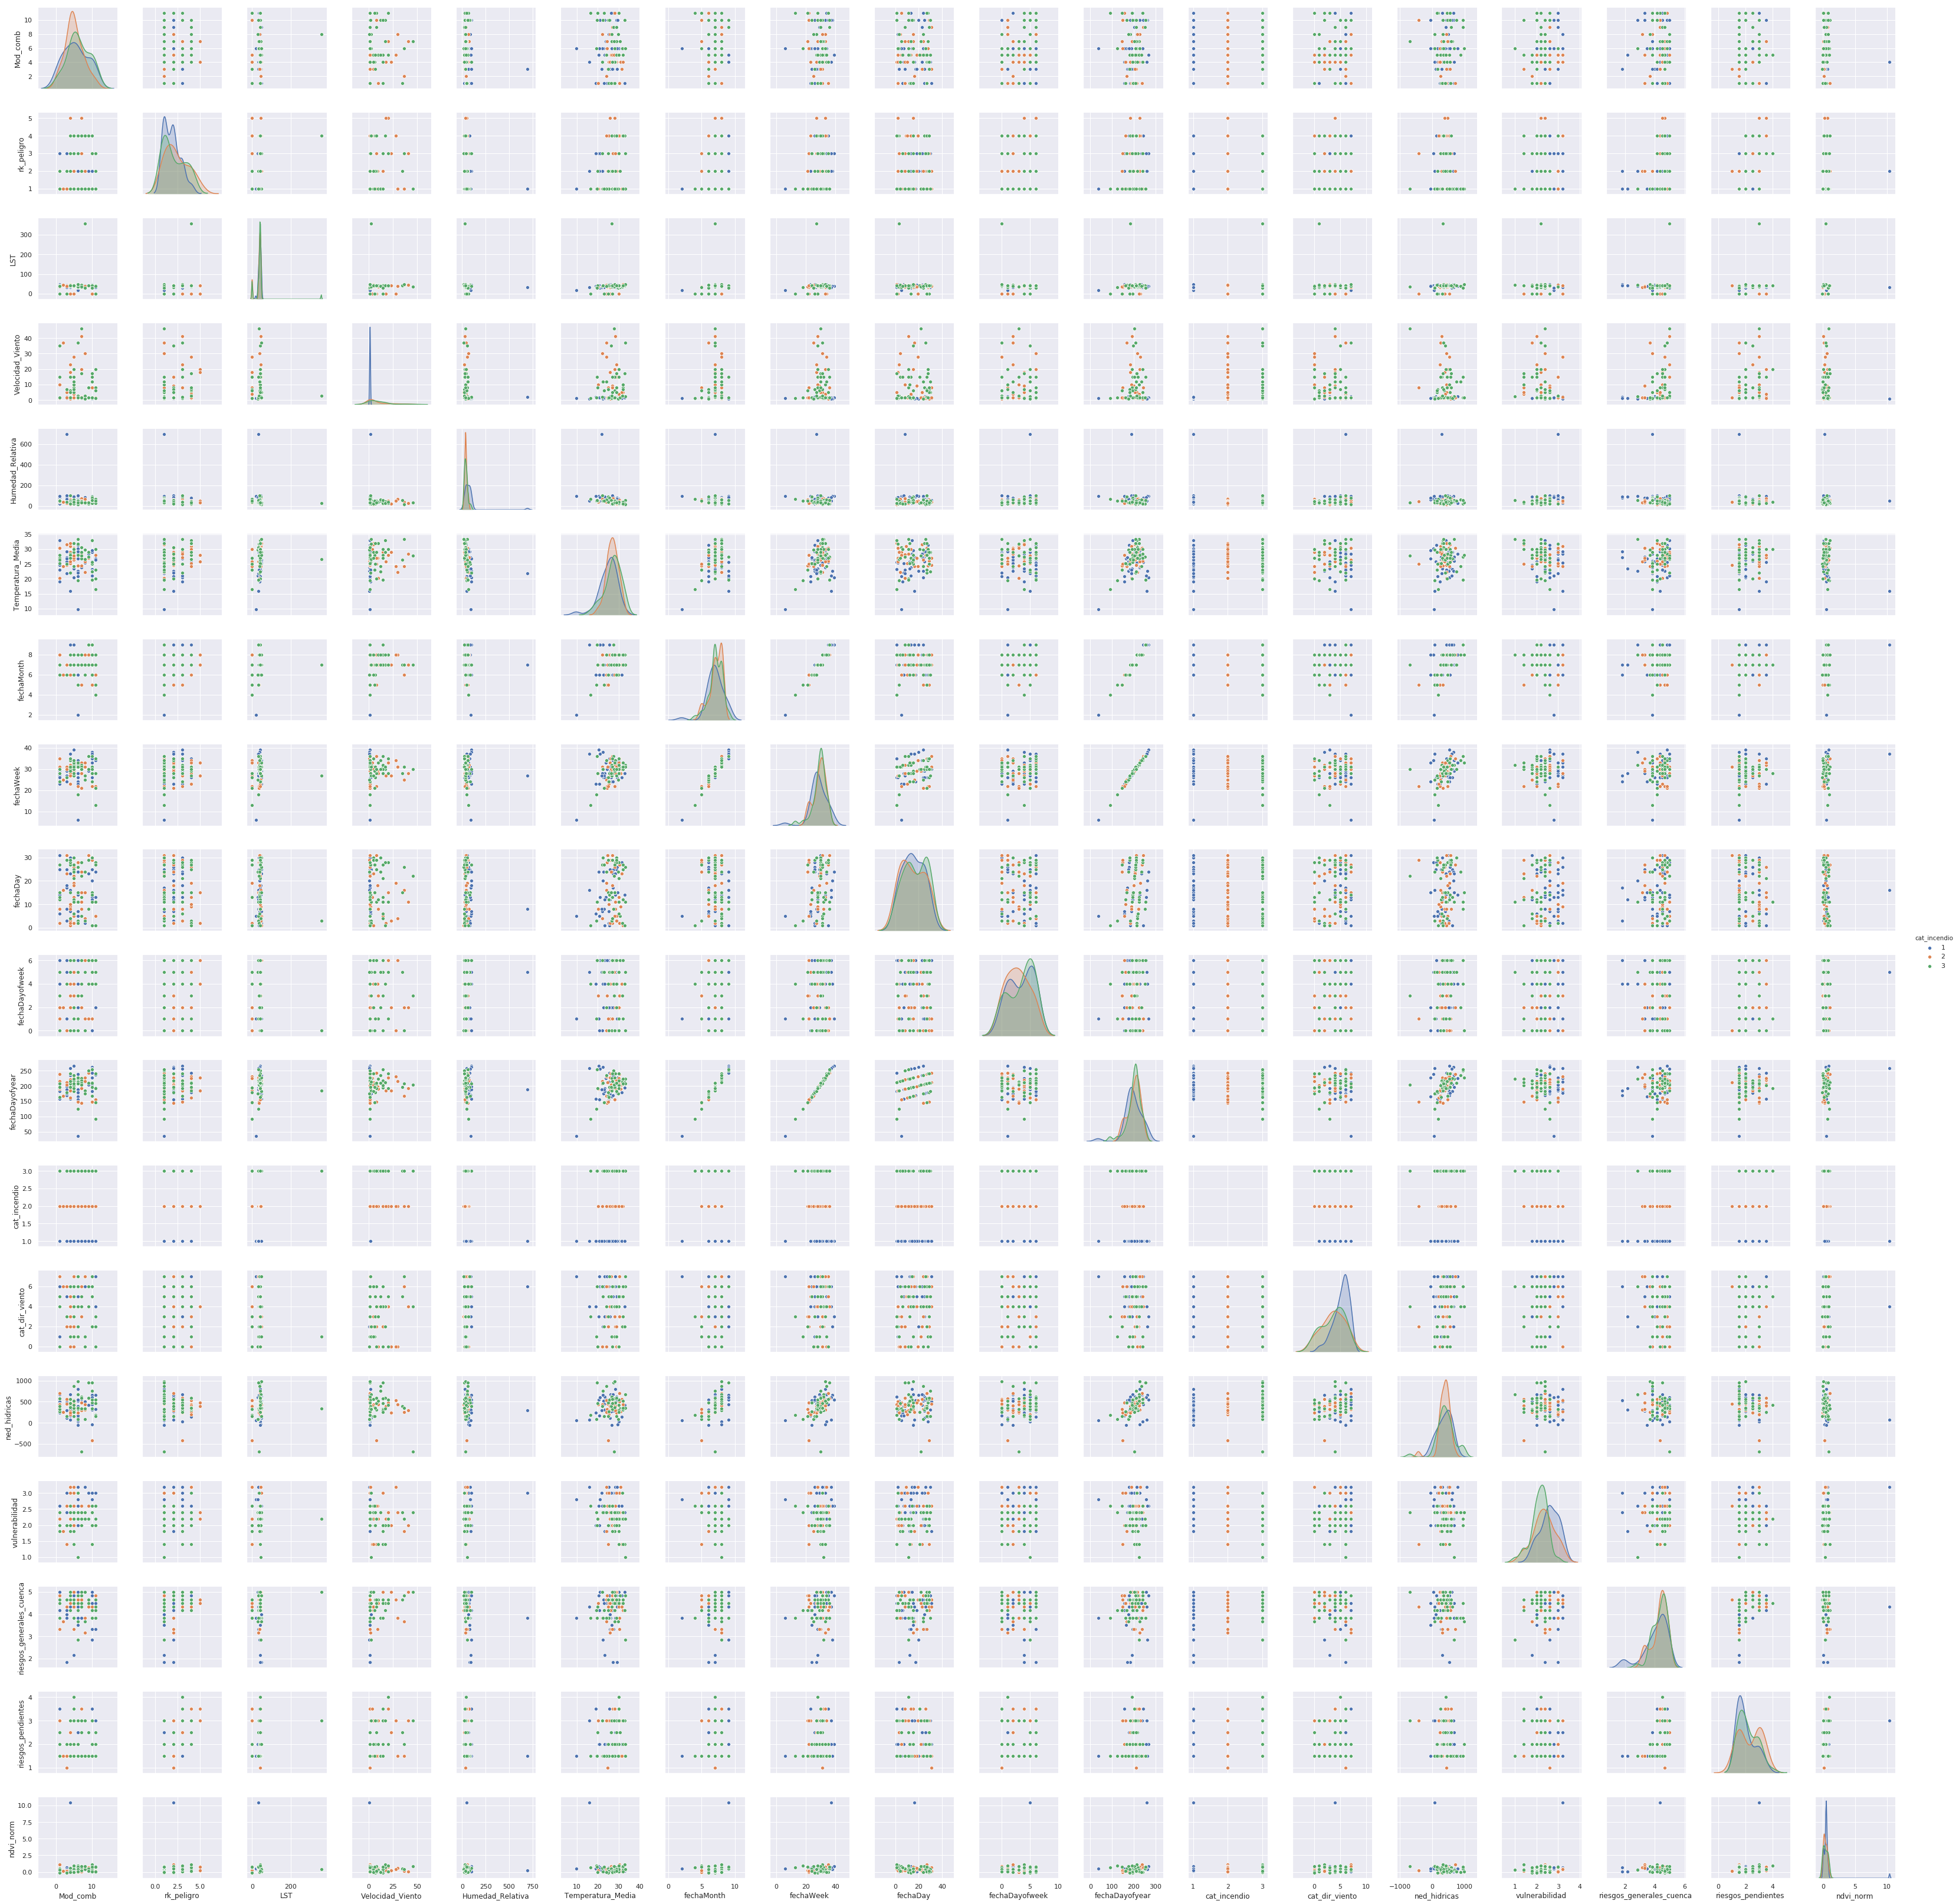

In [37]:
# Visualizar las relaciones entre variables
import seaborn as sns; sns.set()
sns.pairplot(df1,hue="cat_incendio")

# Train/Test y Estandarización

In [38]:
df1.columns

Index(['Mod_comb', 'rk_peligro', 'LST', 'Velocidad_Viento', 'Humedad_Relativa',
       'Temperatura_Media', 'fechaMonth', 'fechaWeek', 'fechaDay',
       'fechaDayofweek', 'fechaDayofyear', 'cat_incendio', 'cat_dir_viento',
       'ned_hidricas', 'vulnerabilidad', 'riesgos_generales_cuenca',
       'riesgos_pendientes', 'ndvi_norm'],
      dtype='object')

In [0]:
#Se separan las entradas de las salidas. La salida está en la columna #11
    outputs = df1.iloc[:,11] # Ponemos en el dataframe "outputs" solo la columna "cat_incendio"
    data_=df1.drop(['cat_incendio'],axis=1) # Ponemos en el dataframe "data" todo el df1 menos "cat_incendio"
    inputs = data_.iloc[:,:] # Lo copiamos a "inputs"
    Input_Data = inputs.values[:,:] # Eliminamos las etiquetas de columna, solo nos quedamos con los valores
    Output_Data = list(outputs.values[:]) # Hacemos lo mismo con la salida



In [0]:
# Separacion muestra: entrenamiento y test
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(Input_Data,Output_Data,test_size=0.3)

In [0]:
# Normalizar valores antes de introducir en el modelo
Scaler = StandardScaler()
X_train = Scaler.fit_transform(X_train)
X_test = Scaler.transform(X_test)

# Primera aproximación modelos (sin optimizar)

In [0]:
## Primera aproximacion de modelos; sin tocar parámetros ##

In [48]:
from sklearn.metrics import accuracy_score, log_loss
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC, NuSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

# La siguiente matriz contiene diferentes algoritmos que serán utilizados a la vez para comparar
classifiers = [
    KNeighborsClassifier(3), # Para cada valor toma los tres valores más cercanos, calcula la moda y le asigna su categoría
    SVC(kernel="rbf", C=0.025, probability=True), 
    NuSVC(probability=True),
    DecisionTreeClassifier(),
    RandomForestClassifier(),
    AdaBoostClassifier(),
    GradientBoostingClassifier(),
    GaussianNB(),
    LinearDiscriminantAnalysis(),
    QuadraticDiscriminantAnalysis()]

# Preparar la visualización del resultado
log_cols=["Classifier", "Accuracy", "Log Loss"]
log = pd.DataFrame(columns=log_cols)

for clf in classifiers:
    clf.fit(X_train, y_train)
    name = clf.__class__.__name__
    
    print("="*30)
    print(name)
    
    print('****Resultadoss****')
    train_predictions = clf.predict(X_test)
    acc = accuracy_score(y_test, train_predictions)
    print("Accuracy: {:.4%}".format(acc))
    train_predictions = clf.predict_proba(X_test)
    ll = log_loss(y_test, train_predictions)
    print("Log Loss: {}".format(ll))
    
    log_entry = pd.DataFrame([[name, acc*100, ll]], columns=log_cols)
    log = log.append(log_entry)
    
print("="*30)

KNeighborsClassifier
****Results****
Accuracy: 51.5152%
Log Loss: 5.825663276746818
SVC
****Results****
Accuracy: 30.3030%
Log Loss: 1.1037287094089243
NuSVC
****Results****
Accuracy: 57.5758%
Log Loss: 1.0177076681448296
DecisionTreeClassifier
****Results****
Accuracy: 36.3636%
Log Loss: 21.97922134221589
RandomForestClassifier
****Results****
Accuracy: 63.6364%
Log Loss: 2.8309601925960353
AdaBoostClassifier
****Results****
Accuracy: 51.5152%
Log Loss: 0.9422908492422771
GradientBoostingClassifier
****Results****
Accuracy: 60.6061%
Log Loss: 1.5771471657581198
GaussianNB
****Results****
Accuracy: 60.6061%
Log Loss: 2.100100452210262
LinearDiscriminantAnalysis
****Results****
Accuracy: 54.5455%
Log Loss: 1.0328320601788992
QuadraticDiscriminantAnalysis
****Results****
Accuracy: 48.4848%
Log Loss: 9.296398954656715


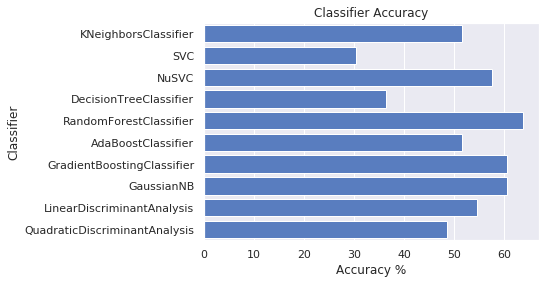

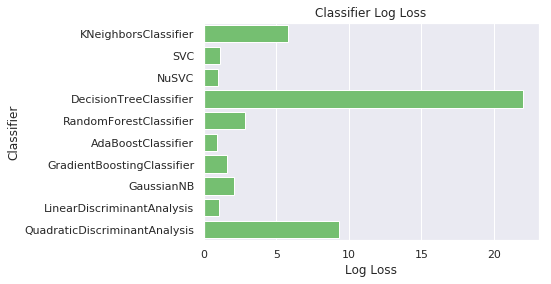

In [49]:
sns.set_color_codes("muted")
sns.barplot(x='Accuracy', y='Classifier', data=log, color="b")

plt.xlabel('Accuracy %')
plt.title('Classifier Accuracy')
plt.show()

sns.set_color_codes("muted")
sns.barplot(x='Log Loss', y='Classifier', data=log, color="g")

plt.xlabel('Log Loss')
plt.title('Classifier Log Loss')
plt.show()

# RANDOM FOREST

In [0]:
### RANDOM FOREST ###

In [0]:
# Parámetros para optimizar el modelo de RF
criterion = ['gini','entropy']
n=[5,10,20,50]
depth=[2,3,5,8,10,30,100]

param_grid = {'criterion': criterion,
              'n_estimators': n,
             'max_depth':depth}


In [0]:
# GridSearch con modelo RF
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
grid = GridSearchCV(RandomForestClassifier(),param_grid=param_grid,n_jobs=1,cv=10,verbose=True) # Crossvalidation = 10

In [52]:
# Entrenar modelo
#y_test_orig= lb.inverse_transform(y_test, threshold=0.5)
grid.fit(X_train,y_train)
pred = grid.predict(X_test)
score = grid.score(X_test,y_test)




Fitting 10 folds for each of 56 candidates, totalling 560 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 560 out of 560 | elapsed:   12.6s finished


In [53]:

conf_mat = confusion_matrix(y_test,pred)
print(conf_mat)
print(score)

[[12  2  0]
 [ 4  1  4]
 [ 5  1  4]]
0.5151515151515151


In [0]:
grid.best_estimator_.feature_importances_

array([0.11429, 0.11408, 0.     , 0.25974, 0.14874, 0.03746, 0.05967, 0.06217, 0.08489, 0.     , 0.02539,
       0.09358])

In [0]:
df1.columns

Index(['Mod_comb', 'rk_peligro', 'LST', 'Velocidad_Viento', 'Humedad_Relativa',
       'Temperatura_Media', 'cat_incendio', 'cat_dir_viento', 'ned_hidricas',
       'vulnerabilidad', 'riesgos_generales_cuenca', 'riesgos_pendientes',
       'ndvi_norm'],
      dtype='object')

In [0]:
df1_columns=df1[['Mod_comb', 'rk_peligro', 'LST', 'Velocidad_Viento', 'Humedad_Relativa',
       'Temperatura_Media','cat_dir_viento', 'ned_hidricas',
       'vulnerabilidad', 'riesgos_generales_cuenca', 'riesgos_pendientes',
       'ndvi_norm']]

In [0]:
df11_columns=df1_columns.columns
print(df11_columns)

Index(['Mod_comb', 'rk_peligro', 'LST', 'Velocidad_Viento', 'Humedad_Relativa',
       'Temperatura_Media', 'cat_dir_viento', 'ned_hidricas', 'vulnerabilidad',
       'riesgos_generales_cuenca', 'riesgos_pendientes', 'ndvi_norm'],
      dtype='object')


In [0]:
feature_importances = pd.DataFrame(grid.best_estimator_.feature_importances_,
                                   index = df1_columns.columns,
                                    columns=['importance']).sort_values('importance',  
                                                                        ascending=False)

In [0]:
feature_importances

,importance
Velocidad_Viento,0.259743
Humedad_Relativa,0.148736
Mod_comb,0.114287
rk_peligro,0.114078
ndvi_norm,0.093579
vulnerabilidad,0.084893
ned_hidricas,0.062165
cat_dir_viento,0.059670
Temperatura_Media,0.037464
riesgos_pendientes,0.025385


In [0]:
## Optimizar modelo con eliminacion de variables

In [0]:
#Se separan las entradas de las salidas
    outputs = df1.iloc[:,6]
    data_=df1.drop(['cat_incendio'],axis=1)
    inputs = data_[['Mod_comb', 'rk_peligro',  'Velocidad_Viento', 'Humedad_Relativa','ndvi_norm']]
    Input_Data = inputs.values[:,:]
    Output_Data = list(outputs.values[:])


In [0]:
X_train,X_test,y_train,y_test = train_test_split(Input_Data,Output_Data,test_size=0.3)
# Normalizar valores antes de introducir en el modelo
Scaler = StandardScaler()
X_train = Scaler.fit_transform(X_train)
X_test = Scaler.transform(X_test)

In [0]:
rf = GridSearchCV(RandomForestClassifier(),param_grid=param_grid,n_jobs=1,cv=10,verbose=True)

rf.fit(X_train,y_train)
pred = rf.predict(X_test)
score = rf.score(X_test,y_test)

conf_mat = confusion_matrix(y_test,pred)
print(conf_mat)
print(score)

Fitting 10 folds for each of 56 candidates, totalling 560 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[[10  4  1]
 [ 3  1  7]
 [ 2  0  4]]
0.46875


[Parallel(n_jobs=1)]: Done 560 out of 560 | elapsed:    9.5s finished


In [0]:
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(len(lb.classes_)):
        fpr[i], tpr[i], _ = roc_curve(y_test, y_score[:, i],pos_label=i)
        roc_auc[i] = auc(fpr[i], tpr[i])
    
    auc = np.trapz(tpr[0],fpr[0])
    x0 = [0,0.2,0.4,0.6,0.8,1]
    y0 = [0,0.2,0.4,0.6,0.8,1]
    plt.title('ROC curve and AUC')
    plt.xlabel('False Positive Ratio')
    plt.ylabel('True Positive Ratio')
    plt.plot(fpr[0],tpr[0],label=str(lb.classes_[1])+", auc="+str(auc))
    auc2 = np.trapz(tpr[1],fpr[1])
    plt.plot(fpr[1],tpr[1],label= str(lb.classes_[1])+", auc="+str(auc2))
    auc3 = np.trapz(tpr[2],fpr[2])
    plt.plot(fpr[2],tpr[2],label= str(lb.classes_[2])+", auc="+str(auc3))
    auc4 = np.trapz(tpr[3],fpr[3])
    plt.plot(fpr[3],tpr[3],label= str(lb.classes_[3])+", auc="+str(auc4))
#    auc5 = np.trapz(tpr[4],fpr[4])
#    plt.plot(fpr[4],tpr[4],label= str(lb.classes_[4])+", auc="+str(auc5))
#    auc6 = np.trapz(tpr[5],fpr[5])
#    plt.plot(fpr[5],tpr[5],label="Class 5, auc="+str(auc6))
    plt.plot(x0,y0,label="X = Y function")
    plt.legend(loc=4)
    plt.show()


AttributeError: ignored

In [0]:
print('\n Score = ' + str(score))
print(grid1.best_params_)
conf = confusion_matrix(lb.inverse_transform(y_test),lb.inverse_transform(grid1.predict(X_test_sc)))

#    y_score = grid1.best_estimator_.decision_function(X_test_sc)
y_score = grid1.best_estimator_.predict_proba(X_test_sc)
    # Compute ROC curve and ROC area for each class
#    fpr = dict()
#    tpr = dict()
#    roc_auc = dict()
#    for i in range(1):
#        fpr[i], tpr[i], _ = roc_curve(y_test, y_score)
#        roc_auc[i] = auc(fpr[i], tpr[i])
    
    # Compute micro-average ROC curve and ROC area
#    fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
#    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
#    plt.xlabel('False Positive Ratio')
#    plt.ylabel('True Positive Ratio')
#    x0 = [0,0.2,0.4,0.6,0.8,1]
#    y0 = [0,0.2,0.4,0.6,0.8,1]
#    plt.plot(fpr[0],tpr[0],label="Class 0, auc="+str(roc_auc['micro']))
#    plt.plot(x0,y0,label="X = Y function")
#    plt.legend(loc=4)
#    plt.show()
    print('Score = ' + str(score))
    print(conf)
    joblib.dump(grid1.best_estimator_,'Z:\Rodalizacion_automatica\Modelizacion\entrenamiento\ESPECIES2.7\Mod_Lidar_Sentinel.pkl')
    joblib.dump(scaler,'Z:\Rodalizacion_automatica\Modelizacion\entrenamiento\ESPECIES2.7\Sc_Lidar_Sentinel.pkl')
    joblib.dump(lb,'Z:\Rodalizacion_automatica\Modelizacion\entrenamiento\ESPECIES2.7\lb_Lidar_Sentinel.pkl')
#    joblib.dump(pca,'PCA_LidarSentinel_Logistic.pkl')
    
#    y_score = grid1.decision_function(X_test_sc)
#    y_score = grid1.decision_function(X_test_sc)
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(len(lb.classes_)):
        fpr[i], tpr[i], _ = roc_curve(y_test, y_score[:, i],pos_label=i)
        roc_auc[i] = auc(fpr[i], tpr[i])
    
    auc = np.trapz(tpr[0],fpr[0])
    x0 = [0,0.2,0.4,0.6,0.8,1]
    y0 = [0,0.2,0.4,0.6,0.8,1]
    plt.title('ROC curve and AUC')
    plt.xlabel('False Positive Ratio')
    plt.ylabel('True Positive Ratio')
    plt.plot(fpr[0],tpr[0],label=str(lb.classes_[1])+", auc="+str(auc))
    auc2 = np.trapz(tpr[1],fpr[1])
    plt.plot(fpr[1],tpr[1],label= str(lb.classes_[1])+", auc="+str(auc2))
    auc3 = np.trapz(tpr[2],fpr[2])
    plt.plot(fpr[2],tpr[2],label= str(lb.classes_[2])+", auc="+str(auc3))
    auc4 = np.trapz(tpr[3],fpr[3])
    plt.plot(fpr[3],tpr[3],label= str(lb.classes_[3])+", auc="+str(auc4))
#    auc5 = np.trapz(tpr[4],fpr[4])
#    plt.plot(fpr[4],tpr[4],label= str(lb.classes_[4])+", auc="+str(auc5))
#    auc6 = np.trapz(tpr[5],fpr[5])
#    plt.plot(fpr[5],tpr[5],label="Class 5, auc="+str(auc6))
    plt.plot(x0,y0,label="X = Y function")
    plt.legend(loc=4)
    plt.show()


In [0]:
# Curva ROC
from sklearn.metrics import roc_curve
fpr_rf, tpr_rf, _ = roc_curve(y_test, pred)

ValueError: ignored

# MLP

In [0]:
### MLP ###

In [0]:
# Parámetros para optimizar el modelo de MLP
parameter_grid_MLP = {
            'hidden_layer_sizes': [(10),(30),(50),(100),(10,10),(30,30),(50,50),(100,100)],
            'solver': ['lbfgs','sgd','adam'],
            'activation' : ['identity','logistic','tanh','relu'],
            'learning_rate': ['constant','adaptive'],
            'alpha': [0.0001,0.001,0.005,0.01]
            }

In [0]:
##MLP###
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import confusion_matrix

mlp = GridSearchCV(MLPClassifier(early_stopping=True),param_grid=parameter_grid_MLP,cv=5,verbose=True,n_jobs=-2)
mlp.fit(X_train,y_train)
params= mlp.best_params_
pred= mlp.predict(X_test)
score= mlp.score(X_test, y_test)
mat= confusion_matrix(y_test,pred)

Fitting 5 folds for each of 768 candidates, totalling 3840 fits


[Parallel(n_jobs=-2)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-2)]: Done 3840 out of 3840 | elapsed:  2.7min finished


In [0]:
print(mat) # matriz de confusión

[[7 1 7]
 [1 2 8]
 [1 1 4]]


In [0]:
print(score) 

0.40625


In [0]:
## hacer curva ROC

# GRADIENT BOOSTING

In [0]:
### GRADIENT BOOSTING ###

In [0]:
learning_rates = [0.05, 0.1, 0.25, 0.5, 0.75, 1]
for learning_rate in learning_rates:
    gb = GradientBoostingClassifier(n_estimators=20, learning_rate = learning_rate, max_features=2, max_depth = 2, random_state = 0)
    gb.fit(X_train, y_train)
    print("Learning rate: ", learning_rate)
    print("Accuracy score (training): {0:.3f}".format(gb.score(X_train, y_train)))
    print("Accuracy score (validation): {0:.3f}".format(gb.score(X_test, y_test)))
    print()

Learning rate:  0.05
Accuracy score (training): 0.905
Accuracy score (validation): 0.594

Learning rate:  0.1
Accuracy score (training): 0.946
Accuracy score (validation): 0.594

Learning rate:  0.25
Accuracy score (training): 1.000
Accuracy score (validation): 0.594

Learning rate:  0.5
Accuracy score (training): 1.000
Accuracy score (validation): 0.531

Learning rate:  0.75
Accuracy score (training): 1.000
Accuracy score (validation): 0.531

Learning rate:  1
Accuracy score (training): 1.000
Accuracy score (validation): 0.531



In [0]:
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
gb = GradientBoostingClassifier(n_estimators=20, learning_rate = 0.5, max_features=2, max_depth = 2, random_state = 0)
gb.fit(X_train, y_train)
predictions = gb.predict(X_test)

print("Confusion Matrix:")
print(confusion_matrix(y_test, predictions))
print()
print("Classification Report")
print(classification_report(y_test, predictions))

Confusion Matrix:
[[10  3  3]
 [ 2  2  1]
 [ 3  3  5]]

Classification Report
              precision    recall  f1-score   support

           1       0.67      0.62      0.65        16
           2       0.25      0.40      0.31         5
           3       0.56      0.45      0.50        11

    accuracy                           0.53        32
   macro avg       0.49      0.49      0.48        32
weighted avg       0.56      0.53      0.54        32



In [0]:
# ROC curve and Area-Under-Curve (AUC)

y_scores_gb = gb.decision_function(X_test)
fpr_gb, tpr_gb, _ = roc_curve(y_test, y_scores_gb)
roc_auc_gb = auc(fpr_gb, tpr_gb)

print("Area under ROC curve = {:0.2f}".format(roc_auc_gb))

ValueError: ignored

# XGBOOST

In [0]:
#### XGBOOST ###

In [0]:

import xgboost as xgb
from scipy.stats import uniform, randint

xgb_model = xgb.XGBClassifier()
    
parameter_grid_XGBOOST = {
            'min_child_weight': [1, 5, 10],
        'gamma': [0.5, 1, 1.5, 2, 5],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'max_depth': [3, 4, 5]
            }
    
    
xgb = GridSearchCV(xgb_model, param_grid=parameter_grid_XGBOOST, cv=3, verbose=1, n_jobs=1, return_train_score=True)
xgb.fit(X_train,np.ravel(y_train))
pred = xgb.predict(X_test)
score = xgb.score(X_test,y_test)
   
conf_mat = confusion_matrix(y_test,pred)
print(conf_mat)
print(score)

Fitting 3 folds for each of 405 candidates, totalling 1215 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[[10  0  0]
 [ 6  0  5]
 [ 2  1  8]]
0.5625


[Parallel(n_jobs=1)]: Done 1215 out of 1215 | elapsed:   37.5s finished


In [0]:
### BAGGING ###

In [0]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier


n=[10,50,70,80,100]
base= [DecisionTreeClassifier(),KNeighborsClassifier()]
param_grid = {'n_estimators': n,
                  'base_estimator':base}

grid = GridSearchCV(BaggingClassifier(),param_grid=param_grid,n_jobs=-2,cv=10,verbose=True)
    
grid.fit(X_train,np.ravel(y_train))
pred = grid.predict(X_test)
score = grid.score(X_test,np.ravel(y_test))
   
conf_mat = confusion_matrix(y_test,pred)
print(conf_mat)
print(score)


Fitting 10 folds for each of 10 candidates, totalling 100 fits


[Parallel(n_jobs=-2)]: Using backend SequentialBackend with 1 concurrent workers.


[[8 1 1]
 [2 5 4]
 [1 4 6]]
0.59375


[Parallel(n_jobs=-2)]: Done 100 out of 100 | elapsed:    5.8s finished


# ADABOOST CLASSIFIER

In [0]:
# ADABOOST CLASSIFIER

In [0]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

dtc = DecisionTreeClassifier(criterion="entropy", max_depth=3)
ada_model=AdaBoostClassifier(base_estimator=dtc, n_estimators=100)
ada_model=ada_model.fit(X_train,y_train)
print(ada_model)
AdaBoostClassifier(algorithm='SAMME.R',
    base_estimator=DecisionTreeClassifier(class_weight=None, 
    criterion='entropy',max_depth=3,
    max_features=None, max_leaf_nodes=None,
    min_impurity_decrease=0.0, min_impurity_split=None,
    min_samples_leaf=1, min_samples_split=2,
    min_weight_fraction_leaf=0.0, presort=False, random_state=None,
    splitter='best'),
    learning_rate=1.0, n_estimators=100, random_state=None)

AdaBoostClassifier(algorithm='SAMME.R',
                   base_estimator=DecisionTreeClassifier(class_weight=None,
                                                         criterion='entropy',
                                                         max_depth=3,
                                                         max_features=None,
                                                         max_leaf_nodes=None,
                                                         min_impurity_decrease=0.0,
                                                         min_impurity_split=None,
                                                         min_samples_leaf=1,
                                                         min_samples_split=2,
                                                         min_weight_fraction_leaf=0.0,
                                                         presort=False,
                                                         random_state=None,
                          

AdaBoostClassifier(algorithm='SAMME.R',
                   base_estimator=DecisionTreeClassifier(class_weight=None,
                                                         criterion='entropy',
                                                         max_depth=3,
                                                         max_features=None,
                                                         max_leaf_nodes=None,
                                                         min_impurity_decrease=0.0,
                                                         min_impurity_split=None,
                                                         min_samples_leaf=1,
                                                         min_samples_split=2,
                                                         min_weight_fraction_leaf=0.0,
                                                         presort=False,
                                                         random_state=None,
                          

In [0]:
ytest_pred=ada_model.predict(X_test)
print(ada_model.score(X_test, y_test))

print(confusion_matrix(y_test, ytest_pred))

0.5625
[[9 3 4]
 [2 1 2]
 [2 1 8]]


In [0]:
# CatBoostClassifier

In [0]:
!pip install catboost

     |████████████████████████████████| 61.2MB 1.4MB/s 


In [0]:
from catboost import CatBoostClassifier
from scipy.stats import uniform as sp_randFloat
from scipy.stats import randint as sp_randInt

In [0]:
    model = CatBoostClassifier()
    parameters = {'depth'         : sp_randInt(4, 10),
                  'learning_rate' : sp_randFloat(),
                  'iterations'    : sp_randInt(10, 100)
                 }
    
    randm = RandomizedSearchCV(estimator=model, param_distributions = parameters, 
                               cv = 2, n_iter = 10, n_jobs=-1)
    randm.fit(X_train, y_train)

    # Results from Random Search
    print("\n========================================================")
    print(" Results from Random Search " )
    print("========================================================")    
    
    print("\n The best estimator across ALL searched params:\n",
          randm.best_estimator_)
    
    print("\n The best score across ALL searched params:\n",
          randm.best_score_)
    
    print("\n The best parameters across ALL searched params:\n",
          randm.best_params_)
    
    print("\n ========================================================")

0:	learn: -1.0962046	total: 47.3ms	remaining: 3.22s
1:	learn: -1.0943370	total: 48.1ms	remaining: 1.61s
2:	learn: -1.0925108	total: 48.9ms	remaining: 1.08s
3:	learn: -1.0906584	total: 49.8ms	remaining: 809ms
4:	learn: -1.0895348	total: 50.7ms	remaining: 649ms
5:	learn: -1.0874793	total: 51.5ms	remaining: 541ms
6:	learn: -1.0853998	total: 52.4ms	remaining: 464ms
7:	learn: -1.0827687	total: 53.3ms	remaining: 406ms
8:	learn: -1.0805245	total: 54.1ms	remaining: 361ms
9:	learn: -1.0791461	total: 55ms	remaining: 324ms
10:	learn: -1.0775489	total: 55.9ms	remaining: 295ms
11:	learn: -1.0761205	total: 56.8ms	remaining: 270ms
12:	learn: -1.0747857	total: 57.7ms	remaining: 248ms
13:	learn: -1.0733126	total: 58.5ms	remaining: 230ms
14:	learn: -1.0709770	total: 59.4ms	remaining: 214ms
15:	learn: -1.0694641	total: 60.2ms	remaining: 199ms
16:	learn: -1.0676472	total: 61.1ms	remaining: 187ms
17:	learn: -1.0669224	total: 61.9ms	remaining: 175ms
18:	learn: -1.0651800	total: 62.8ms	remaining: 165ms
19:	l

# Logistic Classifier

In [0]:
#### LOGISTIC

In [0]:
from sklearn.linear_model import LogisticRegression
# Create regularization penalty space
penalty = ['l1', 'l2']

# Create regularization hyperparameter space
C = np.logspace(0, 4, 10)

# Create hyperparameter options
hyperparameters = dict(C=C, penalty=penalty)



logistic_mod = GridSearchCV(LogisticRegression(),param_grid=hyperparameters,n_jobs=-2,cv=10,verbose=True)


In [0]:

model_res = logistic_mod.fit(X_train, y_train)



Fitting 10 folds for each of 20 candidates, totalling 200 fits


[Parallel(n_jobs=-2)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-2)]: Done 200 out of 200 | elapsed:    0.9s finished


In [0]:
ytest_pred=model_res.predict(X_test)
print(model_res.score(X_test, y_test))

print(confusion_matrix(y_test, ytest_pred))

0.6875
[[10  2  4]
 [ 1  3  1]
 [ 0  2  9]]


In [0]:
############################3

In [0]:
# Cantidad de incendio por meses
print('fechaMonth', df.fechaMonth.value_counts(), sep='\n')

In [0]:
# Cambiamos la variable mes, a variable categórica

for col in ['mes']:
    df[col] = df[col].astype('category')

df.mes.dtype

In [0]:
# Linealizamos la variable categórica (mes) y (año), usando one-hot-encoding.
# Realizamos la codificación

df_encoding = pd.get_dummies(df, columns = ['mes', 'año'])
df_encoding.head()

In [0]:
df_encoding.info()

In [0]:
df_encoding.head()

In [0]:
df_encoding.describe(include='all')

### Análisis univariable: 'sup_quemad'

In [0]:
# Resumen de estadística descriptiva:

df_encoding['sup_quemad'].describe()

In [0]:
# Histograma:

sns.distplot(df_encoding['sup_quemad']);

Se puede observar que en la mayoría de los incendios, la superficie quemada se encuentra en alrededor de 101 hectáreas.

In [0]:
# Asimetría y curtosis:

print("Skewness: %f" % df_encoding['sup_quemad'].skew())
print("Kurtosis: %f" % df_encoding['sup_quemad'].kurt())

In [0]:
# Plotting superficie quemada, arborea, pastizal y matorral

df2 = df.loc[:,["sup_quemad","sup_arb","sup_pastiz","sup_matorr"]]
df2.plot()


En el gráfico anterior podemos observar que las 4 variables, están fuertemente correlacionadas. Para asegurarnos lo podemos ver en la correlación de las varibles que calcularemos a continuación.

Vemos la correlación entre las variables para confirmar la fuerte relación entre los distintos tipos de superficies quemadas.

Aqui tendriamos que plantear eliminar las variables, y quedarnos con la variable <b>sup_quemad</b>.

In [0]:
# Diagrama de dispersión LST/sup_quemad:

var = 'LST'
data = pd.concat([df_encoding['sup_quemad'], df_encoding[var]], axis=1)
data.plot.scatter(x=var, y='sup_quemad', alpha = 0.5);

Se puede apreciar un valor anómalo en <b>LST</b> (temperaturas Modis), hay un valor por encima de 350 que habría que eliminar.

In [0]:
#visualizamos distribuciones
df_encoding.hist(bins=15, figsize=(18,16), ec='w')
plt.show()


In [0]:
plt.hist(df_encoding.sup_quemad, ec='w', bins=100, color='red')
plt.text(4800,15, 'max: '+str(df_encoding.sup_quemad.max()), color='black', fontsize=18)


In [0]:
# Agrupamos las areas quemadas para una mejor comprensión

df_encoding['sup_quemad_cat'] = pd.cut(df_encoding['sup_quemad'], bins=[0,5, 10, 50, 100, 1100], include_lowest=True, 
                                 labels=['0-5','5-10', '10-50', '50-100', '>100'])
df_encoding.sup_quemad_cat.value_counts()

In [0]:
# sup_quemad: área quemada total en hectáreas (ha), debería ser el atributo objetivo.
df_encoding.corr()

In [0]:
#correlation map
f,ax = plt.subplots(figsize=(18, 18))
sns.heatmap(df.corr(), annot=True, linewidths=.5, fmt= '.1f',ax=ax)
plt.show()

In [0]:
corr_matrix = df_encoding.corr(method='spearman')
corr_matrix

In [0]:
corr_matrix.sup_quemad.sort_values(ascending=False)

In [0]:
# visualizando las relaciones de los atributos mas relacionados
attributes = ['sup_quemad', 'sup_matorr', 'sup_arb', 'sup_pastiz']
sns.pairplot(df_encoding[attributes])
plt.show()

In [0]:
df_encoding.plot(subplots = True, figsize = (16,30))
plt.xlabel('Medidas tomadas') 
plt.ylabel('Frequencias')
plt.show()